In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

from utils.data_utils import load_movement_df # import data loading stuff
from utils.plot_utils import *                # import plotting stuff


path_to_data = os.path.join('..', '..', 'data')

# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [2]:
def capitalize_string_df(df_cap, col_cap):
    df_cap[col_cap] = df_cap[col_cap].map(lambda x: ' '.join([w.lower().capitalize() for w in str(x).split(' ')] ) )
    return df_cap

In [3]:
amr_places_df = pd.read_csv(os.path.join(feb_hosp_records_path, "micro_long2021-08-25_place.csv"), parse_dates=["date_long", "date"]).drop(columns=["Unnamed: 0"])
amr_places_df["organism_category"] = amr_places_df["organism_category"].fillna("None")
amr_places_df["abnormal_result"]   = amr_places_df["abnormal_result"].fillna("N")
amr_places_df["organism_group"]    = amr_places_df["organism_group"].fillna("None")
amr_places_df["organism_name"]     = amr_places_df["organism_name"].fillna("None")

amr_places_df                    = capitalize_string_df(amr_places_df, "procedure_description" )
amr_places_df['place'].replace({"1": 'Columbia', "2":'Allen', "3":'Chony'}, inplace=True)
amr_places_df                    = capitalize_string_df(amr_places_df, "site" )
amr_places_df                    = capitalize_string_df(amr_places_df, "ward" )
amr_places_df                    = capitalize_string_df(amr_places_df, "room" )
amr_places_df["num_tests"] = 1


In [4]:
test_ward_df = amr_places_df.groupby(["date",  "place", "site", "ward", "room"]).sum()[["num_tests"]]
test_per_place_ward_df         = test_ward_df.reset_index().groupby(["place", "site", "ward"]).sum()[["num_tests"]].reset_index()
test_per_place_ward_df["ward"] = test_per_place_ward_df.apply(lambda x: x.site+"-"+x.ward, axis=1)
test_per_place_ward_df         = test_per_place_ward_df[test_per_place_ward_df["place"]!="True"]


test_per_place_site_df = test_ward_df.reset_index().groupby(["place", "site"]).sum()[["num_tests"]].reset_index()
test_per_place_site_df = test_per_place_site_df[test_per_place_site_df["place"]!="True"]


In [5]:
import pylab

cm         = pylab.get_cmap('gist_ncar')
NUM_COLORS = test_per_place_site_df["place"].unique().shape[0]
cm(1.*0/NUM_COLORS)
place2color = {place: cm(1.*place_idx/NUM_COLORS) for place_idx, place in enumerate(test_per_place_site_df.place.unique())}

test_per_place_site_df["color"] = test_per_place_site_df["place"].map(place2color)
test_per_place_ward_df["color"] = test_per_place_ward_df["place"].map(place2color)

test_per_place_site_df["log_num_tests"] = np.log(test_per_place_site_df["num_tests"])
test_per_place_ward_df["log_num_tests"] = np.log(test_per_place_ward_df["num_tests"])


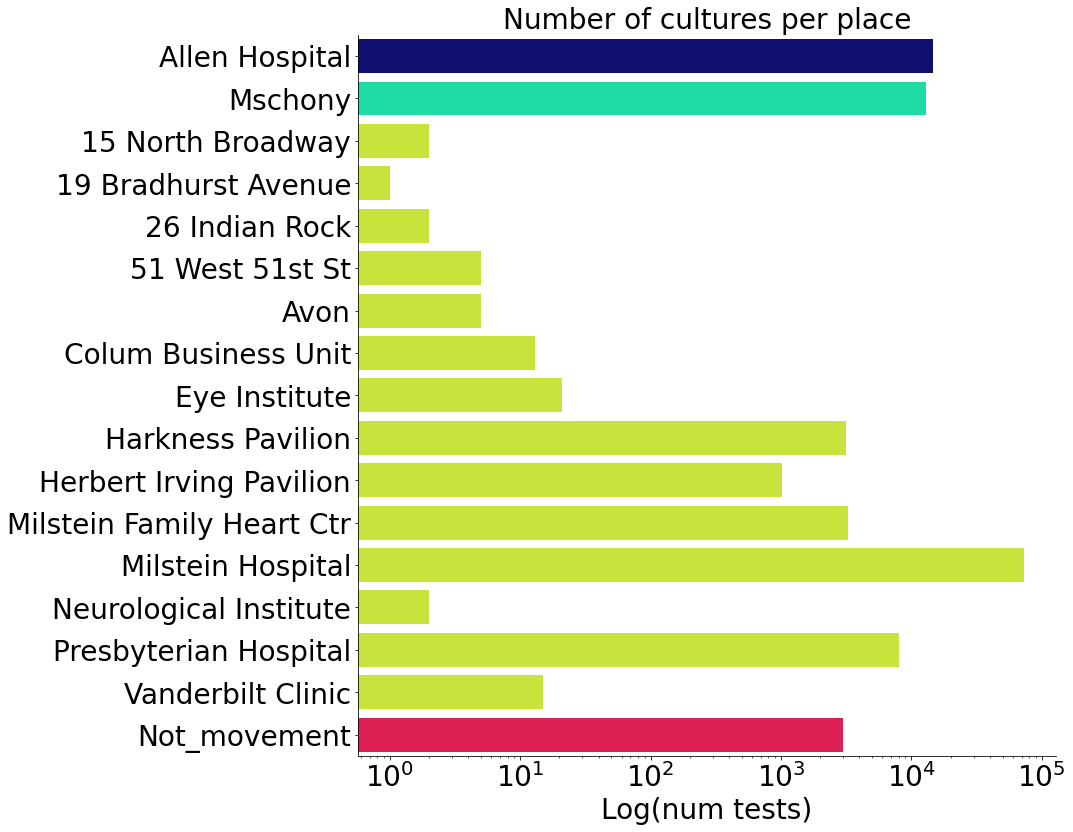

In [6]:
import seaborn as sns


fig, ax = plt.subplots(1, 1, figsize=(15.5, 12.2), sharey=True)
#sns.barplot(ax=ax[0], x="num_tests", y="site", data=test_per_place_site_df,
#            label="Total", palette=test_per_place_site_df["color"].values)

sns.barplot(ax=ax, x="num_tests", y="site", data=test_per_place_site_df,
            label="Total", palette=test_per_place_site_df["color"].values)


ax.set_title("Number of cultures per place")
ax.tick_params(which='both', axis='both')
ax.set_xlabel("Number of tests")
ax.set_ylabel(None)
ax.set_xlabel("Log(num tests)")
ax.set_xscale("log")

sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

plt.tight_layout()

path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "CulturePerPlace.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)



In [12]:
test_per_place_ward_df.place.unique()

array(['Allen', 'Chony', 'Columbia', 'not_movement'], dtype=object)

In [25]:
test_per_place_ward_df["ward_no_place"] = test_per_place_ward_df["ward"].apply(lambda x: x.split("-")[-1])

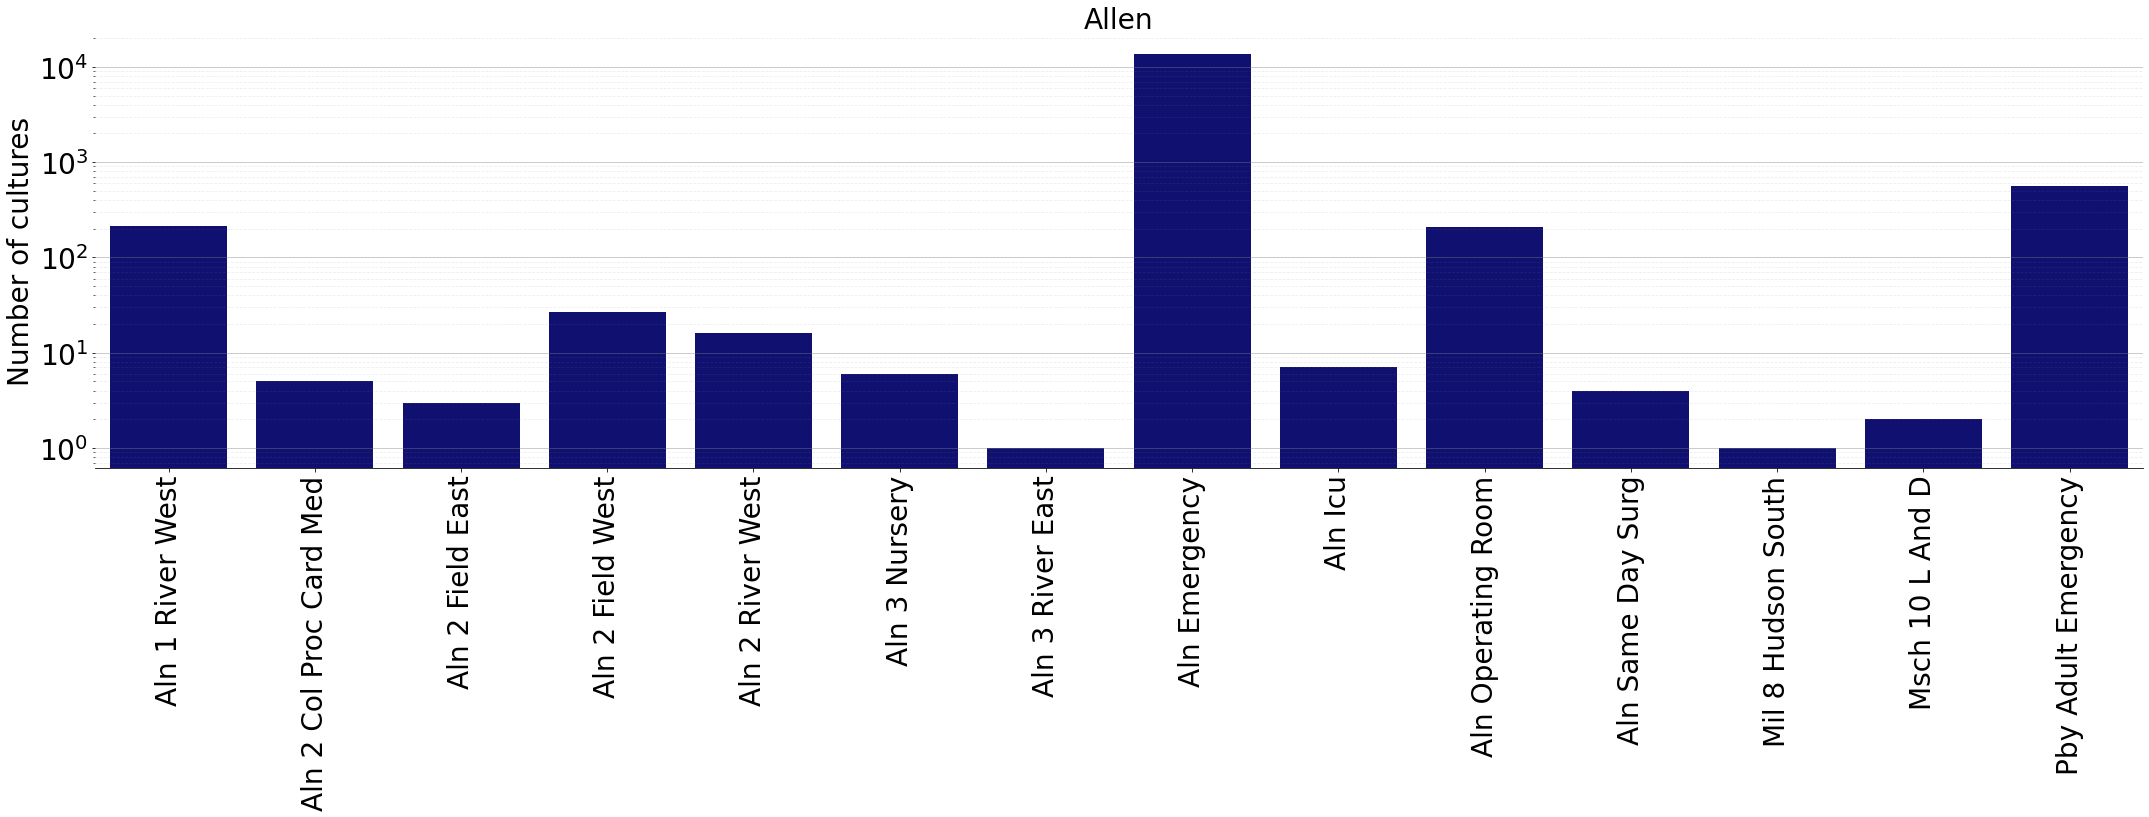

In [43]:

fig, ax = plt.subplots(1, 1, figsize=(30.5, 12), sharey=True)

sns.barplot(ax=ax, y="num_tests", x="ward_no_place", data=test_per_place_ward_df[test_per_place_ward_df.place=="Allen"],
            label="Total", palette=test_per_place_ward_df[test_per_place_ward_df.place=="Allen"]["color"].values)

ax.set_title("Allen")
ax.tick_params(which='both', axis='both')
ax.set_ylabel("Number of cultures")
ax.set_yscale('log')
ax.set_xlabel(None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)

ax.grid(axis='y', linestyle='-', which='major', color='grey', alpha=.5)
ax.grid(axis='y', linestyle='--', which='minor', color='grey', alpha=.15)

plt.tight_layout()

#fig.savefig(os.path.join(path_to_testing_figures, "test_per_ward.png"), dpi=300,  bbox_inches='tight', transparent=True)


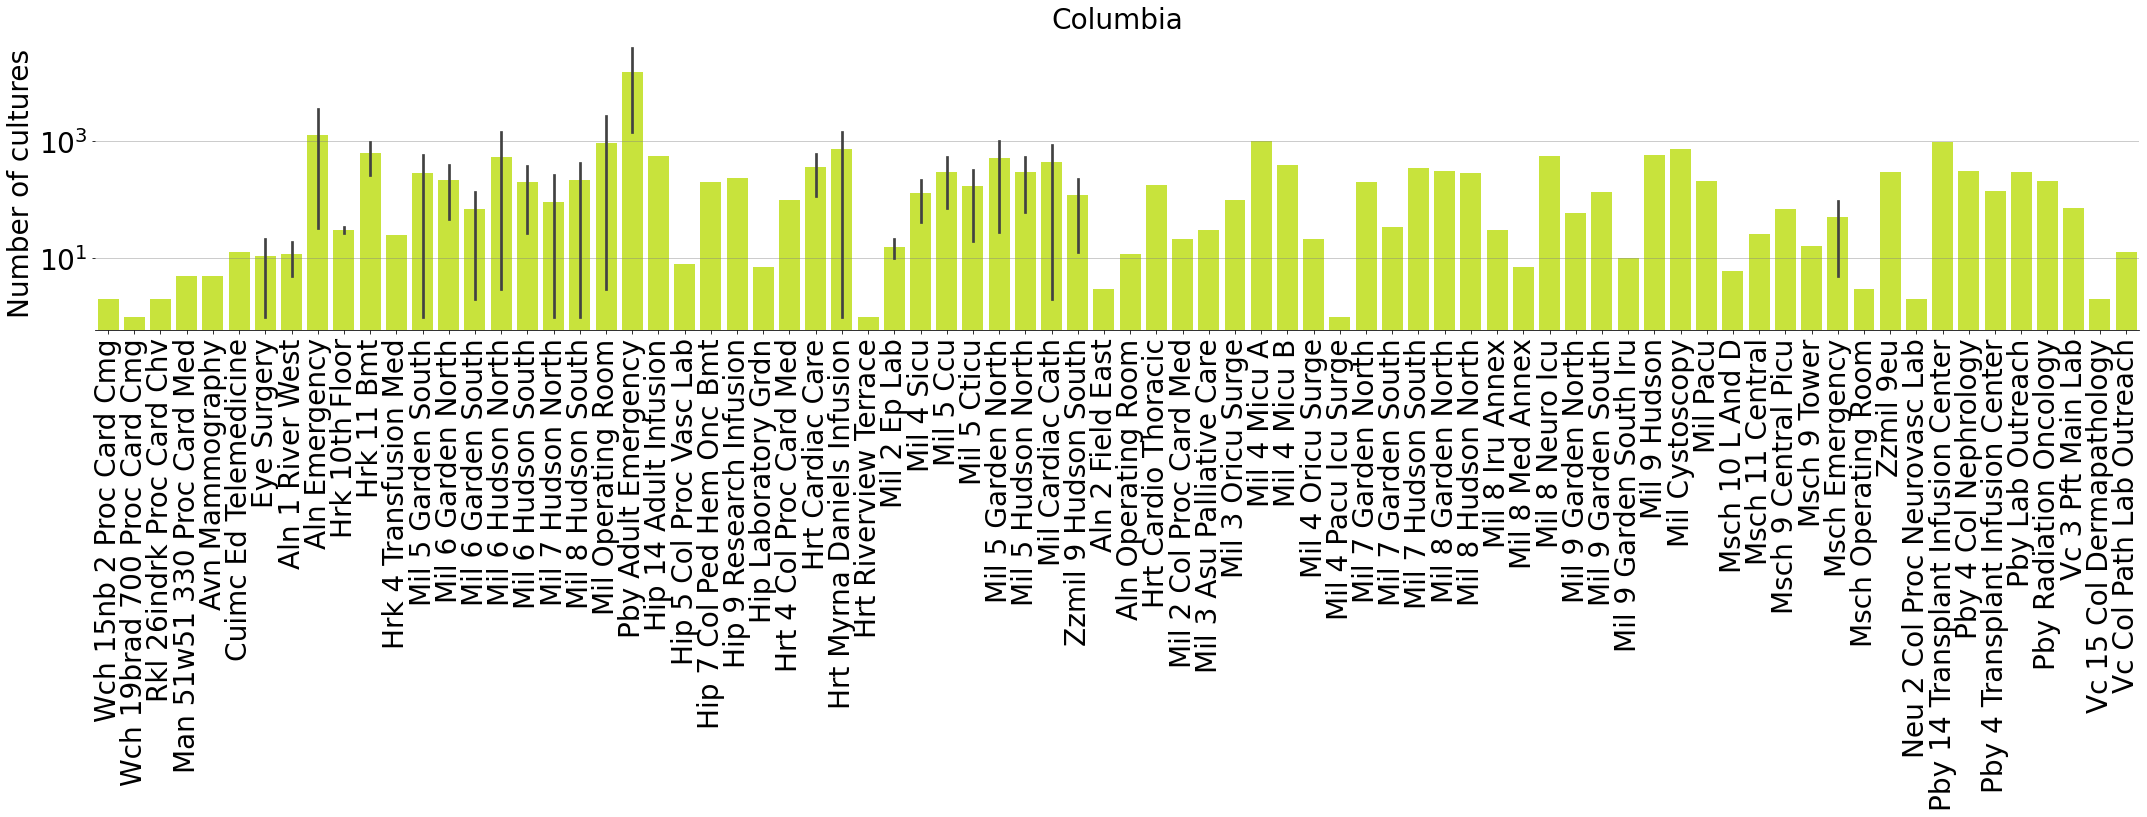

In [41]:

fig, ax = plt.subplots(1, 1, figsize=(30.5, 12), sharey=True)

sns.barplot(ax=ax, y="num_tests", x="ward_no_place", data=test_per_place_ward_df[test_per_place_ward_df.place=="Columbia"],
            label="Total", palette=test_per_place_ward_df[test_per_place_ward_df.place=="Columbia"]["color"].values)

ax.set_title("Columbia")
ax.tick_params(which='both', axis='both')
ax.set_ylabel("Number of cultures")
ax.set_yscale('log')
ax.set_xlabel(None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)

ax.grid(axis='y', linestyle='-', which='major', color='grey', alpha=.5)
ax.grid(axis='y', linestyle='--', which='minor', color='grey', alpha=.15)

plt.tight_layout()

#fig.savefig(os.path.join(path_to_testing_figures, "test_per_ward.png"), dpi=300,  bbox_inches='tight', transparent=True)


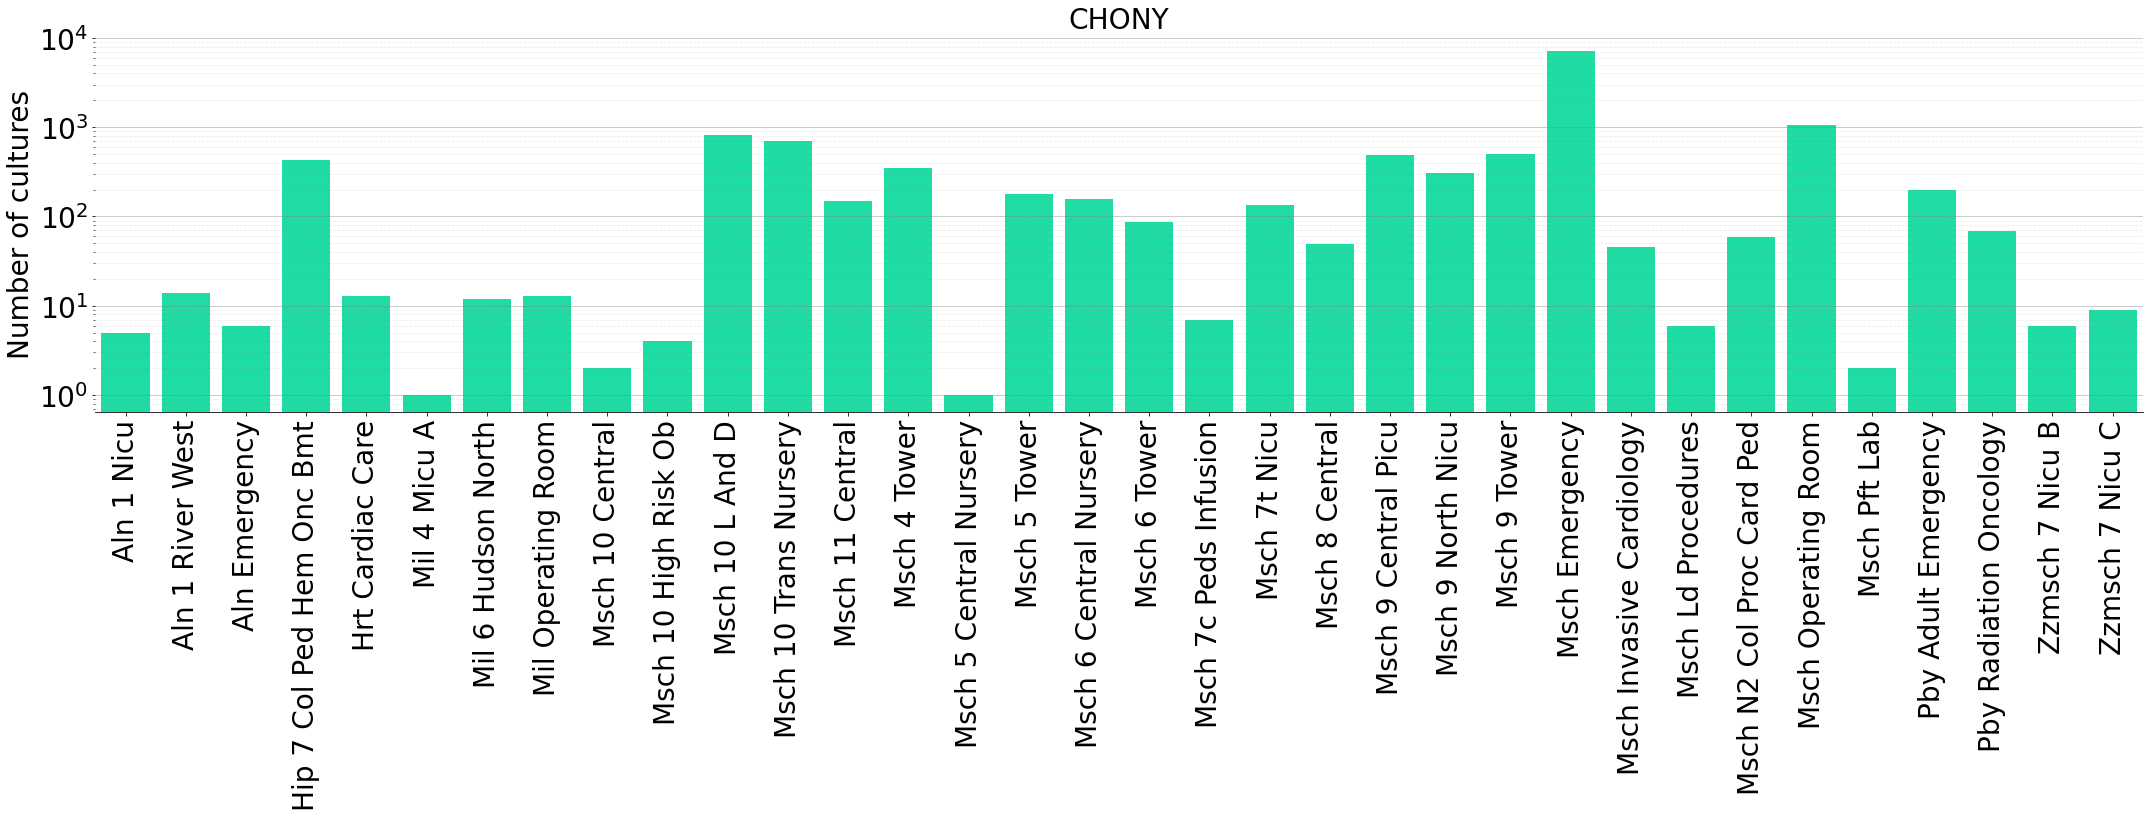

In [42]:

fig, ax = plt.subplots(1, 1, figsize=(30.5, 12), sharey=True)

sns.barplot(ax=ax, y="num_tests", x="ward_no_place", data=test_per_place_ward_df[test_per_place_ward_df.place=="Chony"],
            label="Total", palette=test_per_place_ward_df[test_per_place_ward_df.place=="Chony"]["color"].values)

ax.set_title("CHONY")
ax.tick_params(which='both', axis='both')
ax.set_ylabel("Number of cultures")
ax.set_yscale('log')
ax.set_xlabel(None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)

ax.grid(axis='y', linestyle='-', which='major', color='grey', alpha=.5)
ax.grid(axis='y', linestyle='--', which='minor', color='grey', alpha=.15)

plt.tight_layout()

#fig.savefig(os.path.join(path_to_testing_figures, "test_per_ward.png"), dpi=300,  bbox_inches='tight', transparent=True)
